# Generate QA Validation Dataset with LLM-as-a-Judge

This notebook demonstrates how to generate a **Question-Answer (QA) Validation Dataset** using the **Gemini model**. The process involves extracting text from a PDF document, splitting it into meaningful chunks, and using the Gemini model to generate QA pairs. The generated QA pairs are then evaluated based on several metrics to ensure their quality using LLM-as-a-Judge. Below is an overview of the tools and methods used.

---

## Tools Used

1. **Gemini Model**:
   - A generative AI model used to generate QA pairs from text chunks.
   - Configured to output responses in JSON format for structured data.

2. **Docling**:
   - A library for document conversion and text processing.
   - Used to extract text from PDFs and split it into chunks.

3. **LangChain**:
   - A framework for working with text data, including text splitting and chunking.
   - The `HierarchicalChunker` is used to split text into semantically meaningful chunks.

4. **Google Generative AI**:
   - A library for interacting with Google's generative AI models.
   - Used to call the Gemini model for generating QA pairs.

5. **Pandas**:
   - A library for data manipulation and analysis.
   - Used to store and manage the generated QA pairs in a structured format.

---

## Methods and Steps

### Step 1: Extract Text from PDF
- The text is extracted from a specified PDF document using **Docling's DocumentConverter**.
- The extracted text is processed into a structured format for further analysis.

### Step 2: Split Text into Chunks
- The extracted text is split into smaller chunks using **LangChain's HierarchicalChunker**.
- Only chunks with more than 500 characters are retained to ensure meaningful context.

### Step 3: Generate QA Pairs
- Each text chunk is passed to the **Gemini model** to generate a QA pair.
- The model evaluates whether the chunk contains sufficient context to generate a meaningful question and answer.

### Step 4: Evaluate QA Pairs
- The generated QA pairs are evaluated based on three metrics:
  1. **Groundedness**: How well the question is grounded in the provided context.
  2. **Relevance**: How relevant the question is to the domain (Insurance in this case).
  3. **Standalone**: How self-contained and understandable the question is without additional context.

### Step 5: Store and Log Results
- The QA pairs and their evaluations are stored in a **Pandas DataFrame**.
- The results are logged to **MLflow** for tracking and analysis.

---

## Workflow Overview

1. **Input**: A PDF document containing relevant text.
2. **Processing**:
   - Extract text from the PDF.
   - Split text into meaningful chunks.
   - Generate QA pairs using the Gemini model.
3. **Evaluation**:
   - Evaluate the QA pairs based on groundedness, relevance, and standalone metrics.
4. **Output**: A structured dataset of QA pairs with evaluation scores.

---

## Why This Approach?

- **Automated QA Generation**: The Gemini model automates the generation of QA pairs, saving time and effort.
- **Quality Assurance**: The evaluation metrics ensure that the generated QA pairs are meaningful and relevant.
- **Scalability**: The process can be scaled to handle multiple documents and generate large datasets.

---

Let’s get started! The full workflow is detailed in the code cells below.

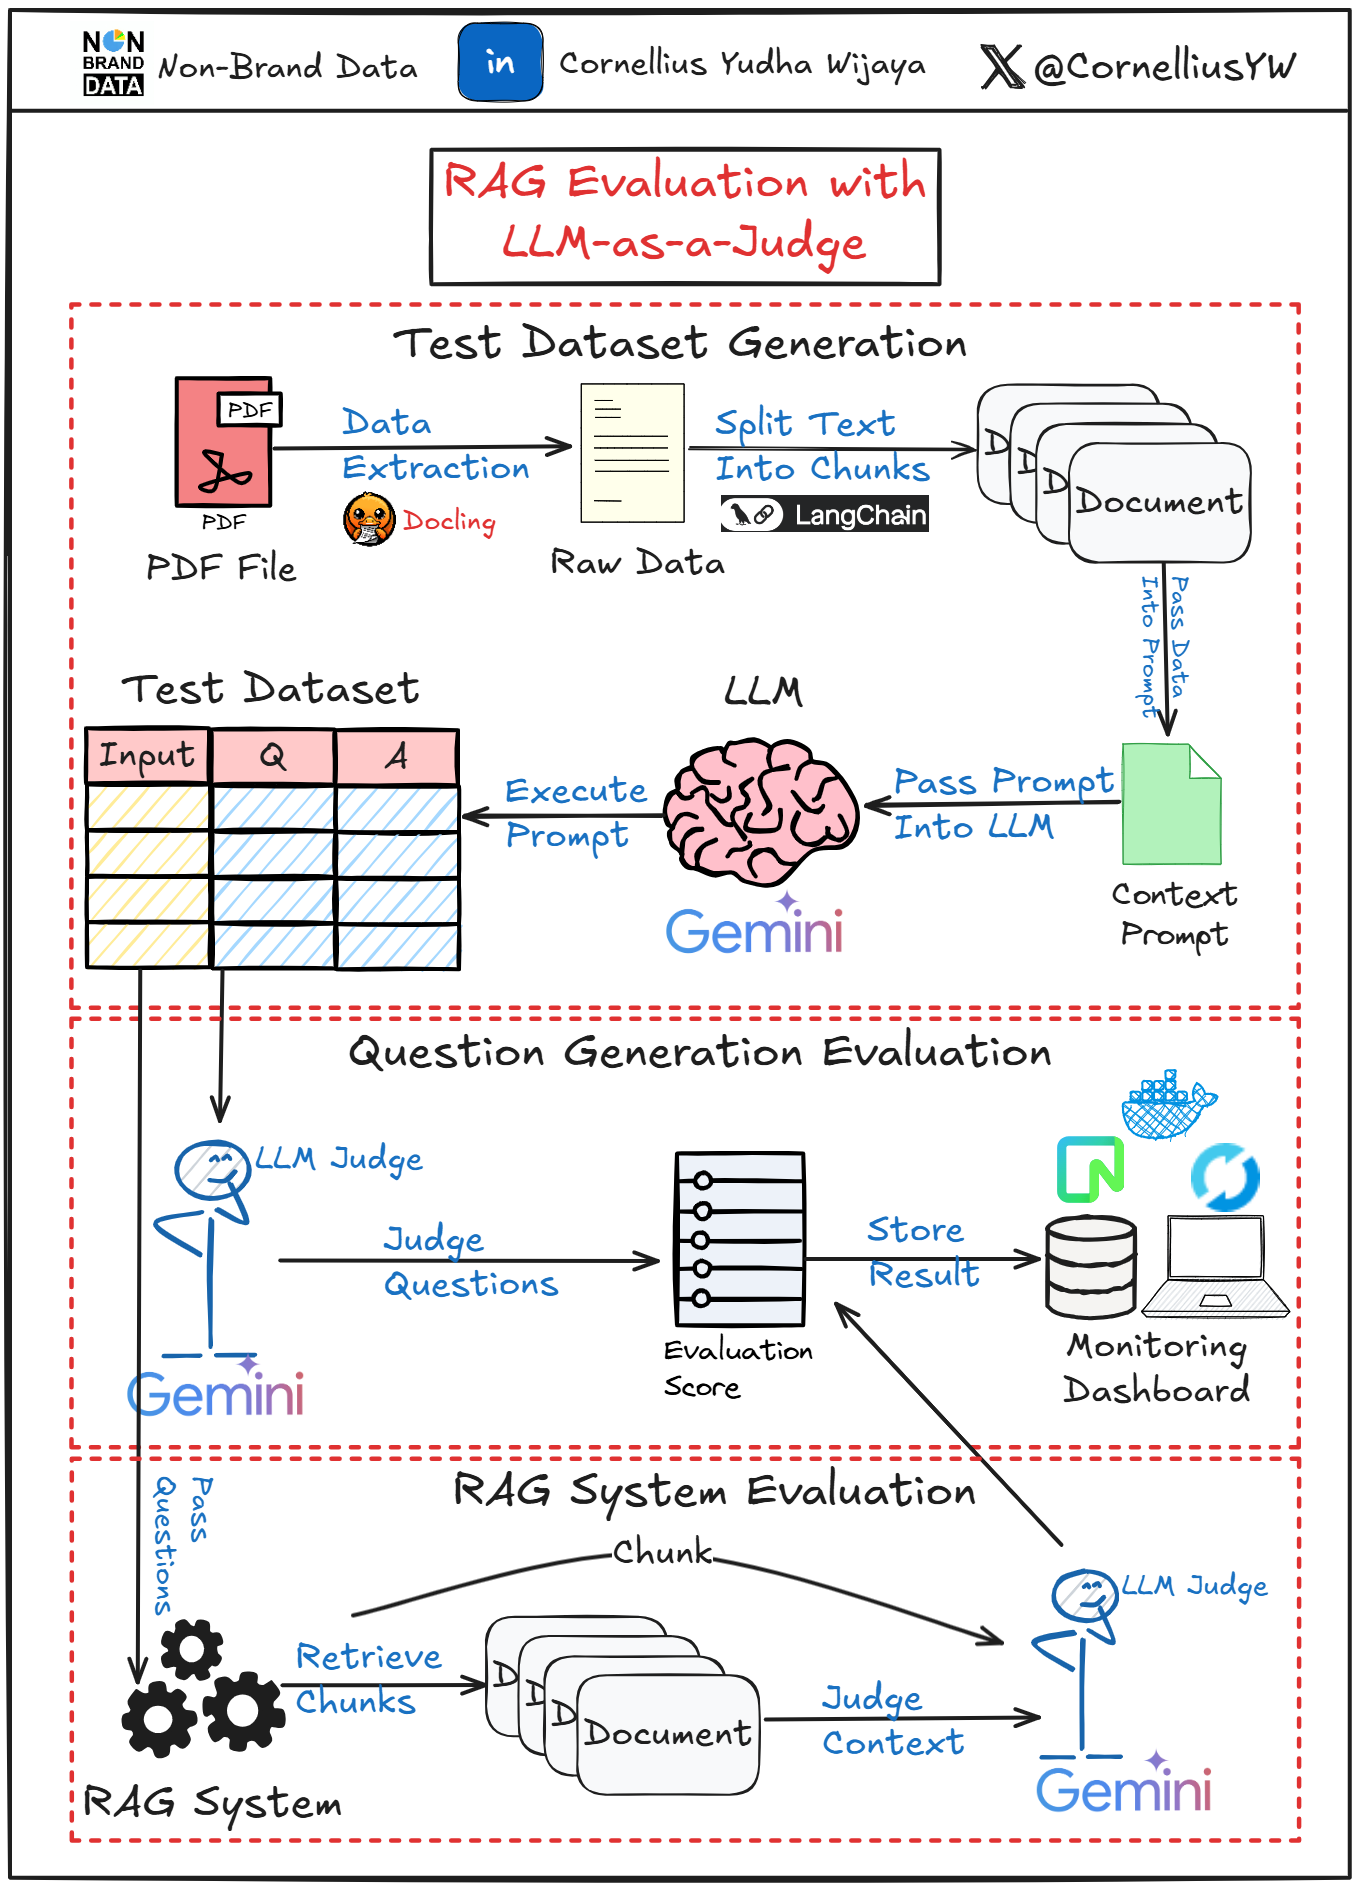

## Library Installation

In [ ]:
!pip install transformers docling google-generativeai

## Set Environment Variables

In [ ]:
import os
# # Set environment variables. Uncomment this if you want to set them directly.
# os.environ["GEMINI_API_KEY"] = "your_gemini_api_key_here"

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

## Data Extraction from PDF

In [ ]:
from docling.document_converter import DocumentConverter

source = "dataset/Insurance_Handbook_20103.pdf"  # PDF path or URL
converter = DocumentConverter()
result = converter.convert(source)

## Splitting Dataset

In [ ]:
from langchain.schema import Document
from docling_core.transforms.chunker import HierarchicalChunker

chunks = list(HierarchicalChunker().chunk(result.document))

chunks = [chunk for chunk in chunks if len(chunk.text) > 500]

LC_docs = [
    Document(page_content=chunk.text, metadata={"source": "Insurance_Handbook_20103"})
    for chunk in chunks
]


## Initiate the Model

In [ ]:
import google.generativeai as genai

# Configure the generative AI model
genai.configure(api_key=GEMINI_API_KEY )

# Instantiate the generative AI regular model
model = genai.GenerativeModel('gemini-1.5-flash')

# Instantiate the generative AI QA model with the response mime type set to JSON
QA_model = genai.GenerativeModel('gemini-1.5-flash',
                                 generation_config = {"response_mime_type":"application/json"})

def call_model(model: genai, prompt:str):
    response = model.generate_content(prompt)
    return response.text

## Prompt Preparation for Generating Question Based on Chunks

In [ ]:
from langchain.prompts import PromptTemplate

Rich_context_prompt = """
You are tasked with evaluating if a given context contains sufficient rich context to generate a fact-based question (factoid) and its answer.

The evaluation should satisfy the rules below:
{rules}

Follow these steps to evaluate the context:
{guidelines}

Here are some examples (delimited by triple backticks):
```
{examples}
```
Now here is the context (delimited by triple quotes):

Context: \"\"\"{context}\"\"\" \n
Please use the JSON schema below for your output:

If the context contains sufficient rich context, generate the output in the following JSON format:
Output = {{
  "question": "insert the generated question here",
  "answer": "insert the corresponding answer here"
}}

If the context lacks sufficient rich context, generate this JSON format:
Output = {{
  "reasoning": "Explain why the context lacks sufficient richness for a question and answer pair.",
  "evaluation": "No"
}}

Return the output in the required JSON format only.
"""

rules = """- The context must present a clear subject or main idea.
- The context must include specific details, facts, or examples.
- The context must contain claims, arguments, or explanations that could be questioned.
- The context must have sufficient depth or complexity to allow meaningful questions to be generated."""

guidelines = """1. Read the context thoroughly to understand its depth and scope.
2. Identify whether the context includes specific details or claims.
3. Assess if a meaningful question can be generated from the information provided.
4. Conclude if the context has "enough rich context" or "lacks sufficient context."
5. Summarize the answer in less than 300 characters."""

examples = """
# Example 1:
## Context: The Earth revolves around the Sun in an elliptical orbit, completing one revolution approximately every 365.25 days.
## Output: {
##   "question": "What is the shape of the Earth's orbit around the Sun, and how long does one revolution take?",
##   "answer": "The Earth's orbit is elliptical, and it takes approximately 365.25 days to complete one revolution."
## }

# Example 2:
## Context: Apples are a type of fruit.
## Output: {
##   "reasoning": "The context is too general and lacks specific details or claims to generate a meaningful question.",
##   "evaluation": "No"
## }
"""

# Create the PromptTemplate
rich_context_template = PromptTemplate(
    template=Rich_context_prompt,
    input_variables=["rules", "guidelines", "examples", "context"]
)


## Sample Result

In [ ]:
import random

sampled_context = random.sample(LC_docs, 1)  # Randomly sample one context
prompt = rich_context_template.format(
    rules=rules,
    guidelines=guidelines,
    examples=examples,
    context=sampled_context[0].page_content,
    format=json_format,
)
output_QA_couple = call_model(QA_model, prompt)


## Generate The QA Dataset

Using 100 chunks example to generate QA Pair dataset

In [ ]:
import time
from tqdm import tqdm
import pandas as pd

# Define Gemini API limits
REQUEST_LIMIT = 15  # Max requests per minute
TOKEN_LIMIT = 1_000_000  # Max tokens per minute

# Function to enforce rate limits
def enforce_rate_limit(start_time, requests_made, tokens_used):
    elapsed_time = time.time() - start_time
    if requests_made >= REQUEST_LIMIT or tokens_used >= TOKEN_LIMIT:
        sleep_time = max(0, 60 - elapsed_time)  # Wait until 1 minute has passed
        time.sleep(sleep_time)
        return time.time(), 0, 0  # Reset counters
    return start_time, requests_made, tokens_used

# Initialize counters
start_time = time.time()
requests_made = 0
tokens_used = 0

N_GENERATIONS = 100  # Number of QA pairs to generate
outputs = []

print(f"Generating {N_GENERATIONS} QA couples...")

for sampled_context in tqdm(random.sample(LC_docs, N_GENERATIONS)):
    # Generate QA pair using the updated prompt
    prompt = rich_context_template.format(
        rules=rules,
        guidelines=guidelines,
        examples=examples,
        context=sampled_context.page_content,
        format=json_format,
    )

    # Enforce rate limit before making the request
    start_time, requests_made, tokens_used = enforce_rate_limit(start_time, requests_made, tokens_used)

    try:
        # Call the model
        output_QA_couple = call_model(QA_model, prompt)

        # Simulate token usage (adjust based on model specifics)
        token_count = len(prompt.split()) + 200  # Estimate ~200 tokens for the response
        tokens_used += token_count

        # Increment request counter
        requests_made += 1

        # Convert the model's output to a dictionary
        output_QA_couple = eval(output_QA_couple)

        # Check for 'question' and 'Answer' if evaluation is positive
        if "question" in output_QA_couple and "Answer" in output_QA_couple:
            question = output_QA_couple['question']
            answer = output_QA_couple['Answer']

            # Ensure the answer is not too long
            assert len(answer) < 400, "Answer is too long"

            # Append the QA pair with context and metadata
            outputs.append({
                "context": sampled_context.page_content,
                "question": question,
                "answer": answer,
                "source_doc": sampled_context.metadata.get("source", "unknown"),
            })
        else:
            # Log reasoning if evaluation is "No"
            print(f"Skipped due to insufficient context: {output_QA_couple.get('reasoning', 'No reasoning provided')}")
    except Exception as e:
        print(f"Skipped context due to error: {e}")

# Convert outputs to a Pandas DataFrame
qa_dataframe = pd.DataFrame(outputs)


In [ ]:
qa_dataframe.to_csv('96_sample_insurance_qa.csv', index = False)

## Set up the Evaluation

We are using 3 metrics here to evaluate the Questions:

1. Groundness
2. Relevance
3. Standalone

In [ ]:
from tqdm import tqdm
import pandas as pd

# Define the domain/topic
topic = "Insurance"

# Define evaluation criteria
question_validation_prompt_template = """
{task}
{evaluation_criteria}

Follow these steps to generate your evaluation:
{evaluation_steps}

Please respond using the following JSON schema:

Answer = {json_format}

You MUST provide values for 'Evaluation:' and 'Score' in your answer.

{question}
{context}

Answer: """

rating_json_format = """
{
    "Evaluation": "your rationale for the rating, as a text",
    "Score": "your rating, as a number between 1 and 5"
}
"""

question_template = """Now here is the question (delimited by triple backticks)
Question: ```{question}```
"""

context_template = """ here are the context (delimited by triple quotes).
Context: \"\"\"{context}\"\"\"\n
"""

# Tasks, evaluation criteria, and steps
groundedness_task = """You will be given a context and a question.
Your task is to evaluate the question based on the given context and provide a score between 1 and 5 according to the following criteria:"""

groundedness_eval = """- Score 1: The context does not provide sufficient information to answer the question in any way.
- Score 2 or 3: The context provides some relevant information, but the question remains partially answerable or is unclear/ambiguous.
- Score 4: The context offers sufficient information to answer the question, but some minor details are missing or unclear.
- Score 5: The context provides all necessary information to answer the question clearly and without ambiguity."""

groundedness_steps = """- Read the context and question carefully.
- Analyse and evaluate the question based on the provided evaluation criteria.
- Provide a scaled score between 1 and 5 that reflects your evaluation."""

relevance_task = """You will be provided with a question that may or may not relate to the {domain} domain.
Your task is to evaluate its usefulness to users seeking information in the {domain} domain and assign a score between 1 and 5 based on the following criteria:"""

relevance_eval = """- Score 1: The question is unrelated to the {domain} domain.
- Score 2 or 3: The question touches on {domain} but leans more towards another domain and is not particularly useful or relevant for {domain}-specific needs.
- Score 4: The question is related to the {domain} domain but lacks direct usefulness or relevance for users looking for valuable information in this domain.
- Score 5: The question is clearly related to the {domain} domain, makes sense, and is likely to be useful to users seeking information within this domain."""

relevance_steps = """- Read the question carefully.
- Analyse and evaluate the question based on the provided evaluation criteria.
- Provide a scaled score between 1 and 5 that reflects your evaluation."""

standalone_task = """You will be given a question.
Your task is to evaluate how context-independent this question is. You need to assess how self-contained and understandable a question is without relying on external context.
The score reflects whether the question makes sense on its own. Questions referring to a specific, unstated context, such as "in the document" or "in the context," should receive a lower score.
Technical terms or acronyms related to {domain} can still qualify for a high score if they are clear to someone with standard domain knowledge and documentation access.
Please provide a score between 1 and 5 based on the following criteria:"""

standalone_eval = """- Score 1: The question is highly dependent on external context and cannot be understood without additional information.
- Score 2: The question clarifies but requires significant additional context to make sense.
- Score 3: The question can mostly be understood but may depend slightly on an external context for complete clarity.
- Score 4: The question is nearly self-contained, with only minor reliance on external context.
- Score 5: The question is entirely self-contained and makes complete sense on its own, without any reliance on external context."""

standalone_steps = """- Read the question carefully.
- Analyse and evaluate the question based on the provided evaluation criteria.
- Provide a scaled score between 1 and 5 that reflects your evaluation."""


## LLM-as-a-Judge in Action

In [ ]:
import json 

# Define the request and token limits
REQUEST_LIMIT = 15  # Maximum requests per minute
TOKEN_LIMIT = 1_000_000  # Maximum tokens per minute

# Initialize counters
start_time = time.time()
requests_made = 0
tokens_used = 0

# Ensure outputs is a list of dictionaries
if isinstance(outputs, pd.DataFrame):
    outputs = outputs.to_dict("records")  # Convert DataFrame to list of dictionaries

# Processing loop with rate limiting
for output in tqdm(outputs):
    evaluations = {}
    for criterion, prompt in [
        ("groundedness", question_validation_prompt_template.format(
            task=groundedness_task,
            evaluation_criteria=groundedness_eval,
            evaluation_steps=groundedness_steps,
            json_format=rating_json_format,
            question=question_template.format(question=output["question"]),
            context=context_template.format(context=output["context"]),
        )),
        ("relevance", question_validation_prompt_template.format(
            task=relevance_task.format(domain=topic),
            evaluation_criteria=relevance_eval.format(domain=topic),
            evaluation_steps=relevance_steps,
            json_format=rating_json_format,
            question=question_template.format(question=output["question"]),
            context=context_template.format(context=output["context"]),
        )),
        ("standalone", question_validation_prompt_template.format(
            task=standalone_task.format(domain=topic),
            evaluation_criteria=standalone_eval.format(domain=topic),
            evaluation_steps=standalone_steps,
            json_format=rating_json_format,
            question=question_template.format(question=output["question"]),
            context="",  # No context needed for standalone evaluation
        )),
    ]:
        # Enforce rate limit before each request
        start_time, requests_made, tokens_used = enforce_rate_limit(start_time, requests_made, tokens_used)

        try:
            # Call the model
            evaluation = call_model(QA_model, prompt)

            # Simulate token usage (adjust based on model and prompt specifics)
            token_count = len(prompt.split()) + 200  # Assume ~200 tokens in response
            tokens_used += token_count

            # Increment request counter
            requests_made += 1

            # Parse the response and store evaluations
            evaluation = json.loads(evaluation)  # Safely parse JSON response
            evaluations[criterion] = {
                "score": int(evaluation["Score"]),
                "eval": evaluation["Evaluation"]
            }

        except Exception as e:
            print(f"Error processing {criterion} evaluation: {e}")
            evaluations[criterion] = {"score": None, "eval": str(e)}

    # Update the output with evaluations
    output.update({
        "groundedness_score": evaluations["groundedness"]["score"],
        "groundedness_eval": evaluations["groundedness"]["eval"],
        "relevance_score": evaluations["relevance"]["score"],
        "relevance_eval": evaluations["relevance"]["eval"],
        "standalone_score": evaluations["standalone"]["score"],
        "standalone_eval": evaluations["standalone"]["eval"],
    })

# Convert outputs to a DataFrame
qa_evaluation_df = pd.DataFrame(outputs)
qa_evaluation_df.to_csv('evaluation_results_question_insurance.csv', index = False)

## Log the Result

In [ ]:
import mlflow
# Log results to MLflow

mlflow.set_tracking_uri("http://localhost:5000")
EXPERIMENT_NAME = "Question-Evaluation-Insurance"
mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("model_name", "gemini-1.5-flash")
    mlflow.log_param("topic", topic)

    # Log aggregated metrics
    groundedness_scores = qa_evaluation_df["groundedness_score"].dropna()
    relevance_scores = qa_evaluation_df["relevance_score"].dropna()
    standalone_scores = qa_evaluation_df["standalone_score"].dropna()

    mlflow.log_metric("average_groundedness_score", groundedness_scores.mean())
    mlflow.log_metric("average_relevance_score", relevance_scores.mean())
    mlflow.log_metric("average_standalone_score", standalone_scores.mean())

    # Optional if you want to store the artifact
    # # Log individual rows as a table
    # for index, row in qa_evaluation_df.iterrows():
    #     mlflow.log_dict(
    #         {
    #             "context": row["context"],
    #             "question": row["question"],
    #             "answer": row["answer"],
    #             "source_doc": row["source_doc"],
    #             "groundedness_score": row["groundedness_score"],
    #             "groundedness_eval": row["groundedness_eval"],
    #             "relevance_score": row["relevance_score"],
    #             "relevance_eval": row["relevance_eval"],
    #             "standalone_score": row["standalone_score"],
    #             "standalone_eval": row["standalone_eval"],
    #         },
    #         f"row_{index}.json",  # Save each row as a JSON file
    #     )

    # # Log the entire DataFrame as a CSV file
    # qa_evaluation_df.to_csv("qa_evaluation_results.csv", index=False)
    # mlflow.log_artifact("qa_evaluation_results.csv")

    print("Results logged to MLflow.")